In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

data = pd.read_csv('data for HA5.csv')
data = data.dropna(subset=[data.columns[1]])
X = data.iloc[:, 0].values
Y = data.iloc[:, 1].values

print(f"Размер выборки: {len(X)}")
print(f"X: min={X.min():.4f}, max={X.max():.4f}, mean={X.mean():.4f}")
print(f"Y: min={Y.min():.4f}, max={Y.max():.4f}, mean={Y.mean():.4f}")
print()

Размер выборки: 5006
X: min=6.5431, max=12.2024, mean=9.3704
Y: min=0.0000, max=12.3633, mean=6.3106



### ЛОКАЛЬНО-ЛИНЕЙНАЯ РЕГРЕССИЯ

In [9]:
def gaussian_kernel(u):
    """Гауссовское ядро"""
    return norm.pdf(u)

def local_linear_fit(X, Y, x0, bandwidth):
    """
    Локально-линейная оценка в точке x0
    Решает взвешенную регрессию: min_a,b sum w_i(x0) * (Y_i - a - b*X_i)^2
    где w_i(x0) = K((X_i - x0)/h)
    """
    n = len(X)
    
    u = (X - x0) / bandwidth
    w = gaussian_kernel(u)
    
    sum_w = np.sum(w)
    sum_wX = np.sum(w * X)
    sum_wY = np.sum(w * Y)
    sum_wX2 = np.sum(w * X * X)
    sum_wXY = np.sum(w * X * Y)
    
    det = sum_w * sum_wX2 - sum_wX * sum_wX
    
    if abs(det) < 1e-10:
        return None
    
    a = (sum_wX2 * sum_wY - sum_wX * sum_wXY) / det
    b = (sum_w * sum_wXY - sum_wX * sum_wY) / det
    
    return a + b * x0

def cross_validation_loocv(X, Y, bandwidth):
    """
    Leave-one-out cross-validation для заданного bandwidth
    """
    n = len(X)
    cv_error = 0
    
    for i in range(n):
        X_train = np.delete(X, i)
        Y_train = np.delete(Y, i)
        
        y_pred = local_linear_fit(X_train, Y_train, X[i], bandwidth)
        
        if y_pred is not None:
            cv_error += (Y[i] - y_pred) ** 2
    
    return cv_error / n

print("КРОСС-ВАЛИДАЦИЯ ДЛЯ ВЫБОРА BANDWIDTH")

range_X = X.max() - X.min()
bandwidths = np.linspace(0.05 * range_X, 0.5 * range_X, 30)
cv_scores = []

for h in bandwidths:
    cv = cross_validation_loocv(X, Y, h)
    cv_scores.append(cv)
    print(f"Bandwidth = {h:.4f}, CV score = {cv:.6f}")

cv_scores = np.array(cv_scores)
optimal_idx = np.argmin(cv_scores)
optimal_bandwidth = bandwidths[optimal_idx]

print()
print(f"Оптимальный bandwidth: {optimal_bandwidth:.4f}")
print(f"Минимальный CV score: {cv_scores[optimal_idx]:.6f}")
print()

x_grid = np.linspace(X.min(), X.max(), 100)
y_local_linear = np.array([local_linear_fit(X, Y, x, optimal_bandwidth) for x in x_grid])

y_pred_ll = np.array([local_linear_fit(X, Y, x, optimal_bandwidth) for x in X])
mse_local_linear = np.mean((Y - y_pred_ll) ** 2)

print(f"MSE локально-линейной регрессии: {mse_local_linear:.6f}")
print()


КРОСС-ВАЛИДАЦИЯ ДЛЯ ВЫБОРА BANDWIDTH
Bandwidth = 0.2830, CV score = 2.390644
Bandwidth = 0.3708, CV score = 2.389313
Bandwidth = 0.4586, CV score = 2.388513
Bandwidth = 0.5464, CV score = 2.387948
Bandwidth = 0.6342, CV score = 2.387537
Bandwidth = 0.7221, CV score = 2.387266
Bandwidth = 0.8099, CV score = 2.387114
Bandwidth = 0.8977, CV score = 2.387056
Bandwidth = 0.9855, CV score = 2.387071
Bandwidth = 1.0733, CV score = 2.387139
Bandwidth = 1.1611, CV score = 2.387242
Bandwidth = 1.2490, CV score = 2.387368
Bandwidth = 1.3368, CV score = 2.387508
Bandwidth = 1.4246, CV score = 2.387654
Bandwidth = 1.5124, CV score = 2.387800
Bandwidth = 1.6002, CV score = 2.387944
Bandwidth = 1.6880, CV score = 2.388083
Bandwidth = 1.7759, CV score = 2.388216
Bandwidth = 1.8637, CV score = 2.388343
Bandwidth = 1.9515, CV score = 2.388461
Bandwidth = 2.0393, CV score = 2.388573
Bandwidth = 2.1271, CV score = 2.388677
Bandwidth = 2.2149, CV score = 2.388774
Bandwidth = 2.3028, CV score = 2.388865
Ban

### КВАДРАТИЧНАЯ РЕГРЕССИЯ

In [10]:
X_design = np.column_stack([np.ones(len(X)), X, X**2])

beta = np.linalg.solve(X_design.T @ X_design, X_design.T @ Y)

print(f"Коэффициенты: a = {beta[0]:.6f}, b = {beta[1]:.6f}, c = {beta[2]:.6f}")
print(f"Модель: Y = {beta[0]:.4f} + {beta[1]:.4f}*X + {beta[2]:.4f}*X^2")
print()

y_pred_quad = X_design @ beta
mse_quadratic = np.mean((Y - y_pred_quad) ** 2)

print(f"MSE квадратичной регрессии: {mse_quadratic:.6f}")
print()

X_grid_design = np.column_stack([np.ones(len(x_grid)), x_grid, x_grid**2])
y_quadratic = X_grid_design @ beta

print("СРАВНЕНИЕ МОДЕЛЕЙ")
print(f"MSE локально-линейной: {mse_local_linear:.6f}")
print(f"MSE квадратичной:      {mse_quadratic:.6f}")
print(f"Разница MSE:          {abs(mse_local_linear - mse_quadratic):.6f}")
print()

if mse_local_linear < mse_quadratic:
    print("Локально-линейная регрессия показывает лучшее качество подгонки")
else:
    print("Квадратичная регрессия показывает лучшее качество подгонки")


Коэффициенты: a = 9.171898, b = -1.185281, c = 0.093423
Модель: Y = 9.1719 + -1.1853*X + 0.0934*X^2

MSE квадратичной регрессии: 2.383663

СРАВНЕНИЕ МОДЕЛЕЙ
MSE локально-линейной: 2.383969
MSE квадратичной:      2.383663
Разница MSE:          0.000306

Квадратичная регрессия показывает лучшее качество подгонки


### ВИЗУАЛИЗАЦИЯ


Графики сохранены в файл 'regression_comparison.png'


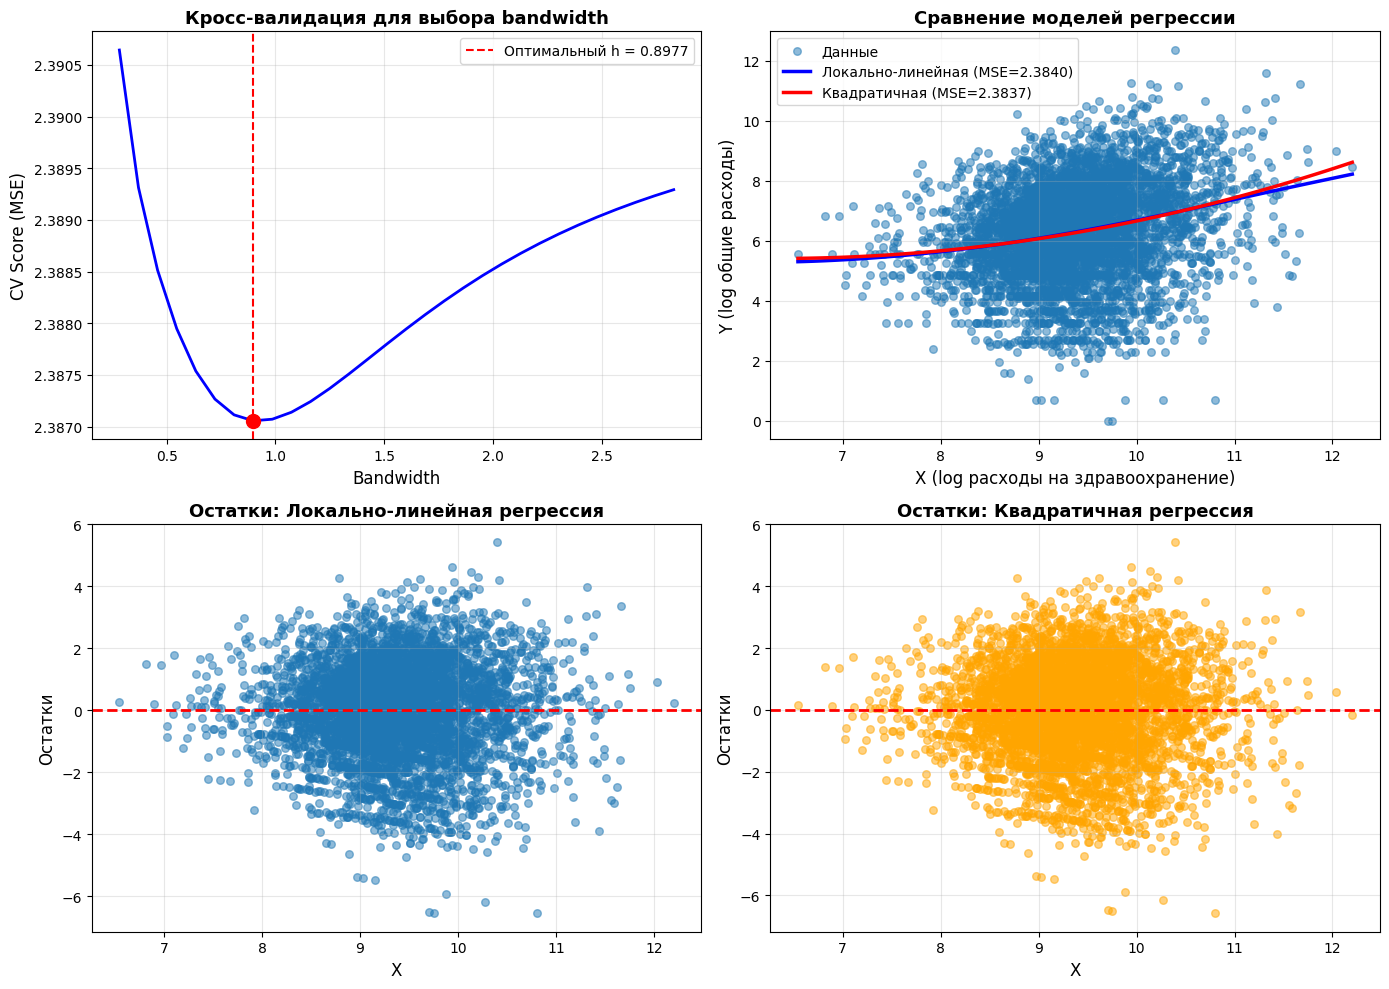

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(bandwidths, cv_scores, 'b-', linewidth=2)
axes[0, 0].axvline(optimal_bandwidth, color='r', linestyle='--', 
                   label=f'Оптимальный h = {optimal_bandwidth:.4f}')
axes[0, 0].scatter([optimal_bandwidth], [cv_scores[optimal_idx]], 
                   color='r', s=100, zorder=5)
axes[0, 0].set_xlabel('Bandwidth', fontsize=12)
axes[0, 0].set_ylabel('CV Score (MSE)', fontsize=12)
axes[0, 0].set_title('Кросс-валидация для выбора bandwidth', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].scatter(X, Y, alpha=0.5, s=30, label='Данные')
axes[0, 1].plot(x_grid, y_local_linear, 'b-', linewidth=2.5, 
                label=f'Локально-линейная (MSE={mse_local_linear:.4f})')
axes[0, 1].plot(x_grid, y_quadratic, 'r-', linewidth=2.5, 
                label=f'Квадратичная (MSE={mse_quadratic:.4f})')
axes[0, 1].set_xlabel('X (log расходы на здравоохранение)', fontsize=12)
axes[0, 1].set_ylabel('Y (log общие расходы)', fontsize=12)
axes[0, 1].set_title('Сравнение моделей регрессии', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

residuals_ll = Y - y_pred_ll
axes[1, 0].scatter(X, residuals_ll, alpha=0.5, s=30)
axes[1, 0].axhline(0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('X', fontsize=12)
axes[1, 0].set_ylabel('Остатки', fontsize=12)
axes[1, 0].set_title('Остатки: Локально-линейная регрессия', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

residuals_quad = Y - y_pred_quad
axes[1, 1].scatter(X, residuals_quad, alpha=0.5, s=30, color='orange')
axes[1, 1].axhline(0, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('X', fontsize=12)
axes[1, 1].set_ylabel('Остатки', fontsize=12)
axes[1, 1].set_title('Остатки: Квадратичная регрессия', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('regression_comparison.png', dpi=300, bbox_inches='tight')
print("\nГрафики сохранены в файл 'regression_comparison.png'")
plt.show()